In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2

Using TensorFlow backend.


In [2]:
def prepare_data(mode):
    """ divides data into images and labels
        Min-Max scales images
    Params:
        mode : String (either "padded" or "resized")
    Returns:
        scaled_X : array with images
        y : array with corresponding labels
        (0 for non-IDC, 1 for IDC)
    """
    patches = glob.glob('./' + mode + '/*.png', recursive=True)
    class0 = []
    class1 = []
    for name in glob.glob('./' + mode + '/*class0.png', recursive=True):
        class0.append(name)
    for name in glob.glob('./' + mode + '/*class1.png', recursive=True):
        class1.append(name)
    X = []
    y = []
    for img_name in patches:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name in class0 else y.append(1)
    scaled_X = np.array(X)/255.0
    return scaled_X, y

In [3]:
def create_CNN():
    input_shape = (50, 50, 3)
    num_classes = 2
    reg = 0.0001
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [4]:
cnn_pad = create_CNN()
cnn_pad.summary()
plot_model(cnn_pad, to_file='simple_cnn_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
__________

In [5]:
X_pad, y = prepare_data("padded")

X_train_tune, X_test, y_train_tune, y_test = train_test_split(X_pad, y, test_size=0.1, random_state=42)

y_train_tune_onehot = np_utils.to_categorical(y_train_tune, 2)
y_test_onehot = np_utils.to_categorical(y_test, 2)

epochs = 20
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, mode='auto')

fit_history = cnn_pad.fit(X_train_tune, y_train_tune_onehot,
                      batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      verbose=1, validation_split=0.1, callbacks=[early_stopping])

Train on 9720 samples, validate on 1080 samples
Epoch 1/20
9720/9720 [==============================] - 157s 16ms/step - loss: 0.5068 - acc: 0.8480 - val_loss: 1.7287 - val_acc: 0.7824
Epoch 2/20
9720/9720 [==============================] - 157s 16ms/step - loss: 0.3660 - acc: 0.8927 - val_loss: 1.5830 - val_acc: 0.7954
Epoch 3/20
9720/9720 [==============================] - 156s 16ms/step - loss: 0.3308 - acc: 0.9071 - val_loss: 0.6839 - val_acc: 0.8370
Epoch 4/20
9720/9720 [==============================] - 157s 16ms/step - loss: 0.3032 - acc: 0.9153 - val_loss: 0.4123 - val_acc: 0.8870
Epoch 5/20
9720/9720 [==============================] - 156s 16ms/step - loss: 0.2808 - acc: 0.9214 - val_loss: 1.0588 - val_acc: 0.8139
Epoch 6/20
9720/9720 [==============================] - 156s 16ms/step - loss: 0.2658 - acc: 0.9245 - val_loss: 0.6057 - val_acc: 0.8380
Epoch 7/20
9720/9720 [==============================] - 156s 16ms/step - loss: 0.2455 - acc: 0.9336 - val_loss: 0.4017 - val_acc: 

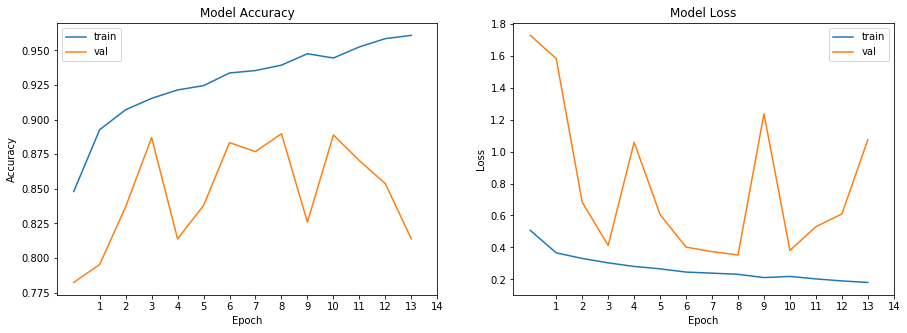

In [6]:
def plot_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_xticks(np.arange(1, len(history.history['acc'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_history(fit_history)

In [7]:
#score_pad = cnn_pad.evaluate(X_test, y_test_onehot, verbose=0)
#print('Test loss:', score_pad[0])
#print('Test accuracy:', score_pad[1])

#plt.plot(fit_history.history['loss'])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Simple CNN with padded imgs')
#plt.show()